<a href="https://colab.research.google.com/github/giovadg/physnum_CUDA/blob/main/waves_pde/Esercizio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/ach.h -nv -O ach.h
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/nvtx3.hpp -nv -O nvtx3.hpp

2025-11-17 12:25:12 URL:https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/ach.h [5329/5329] -> "ach.h" [1]
2025-11-17 12:25:13 URL:https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/nvtx3.hpp [105839/105839] -> "nvtx3.hpp" [1]


In [ ]:
# !nvcc -o /tmp/a.out --extended-lambda Sources/port-thrust-to-gpu.cpp -x cu -arch=native # build executable
# !/tmp/a.out # run executable

Sources/port-thrust-to-gpu.cpp(86): error: identifier "ConfigFile" is undefined
    ConfigFile configFile(inputPath);
    ^

1 error detected in the compilation of "Sources/port-thrust-to-gpu.cpp".
/bin/bash: line 1: /tmp/a.out: No such file or directory


In [142]:
%%writefile test.cpp
//#include "ach.h"

#include <iostream>
#include <vector>
#include <fstream>
#include <cmath>
#include <cstdlib>
#include "ach.h"

#include <thrust/transform.h>
#include <thrust/tabulate.h>
#include <thrust/universal_vector.h>
#include <thrust/iterator/counting_iterator.h>
#include <thrust/iterator/transform_iterator.h>
#include <thrust/reduce.h>
#include <thrust/sort.h>
#include <thrust/copy.h>
#include <thrust/for_each.h>
#include <thrust/fill.h>
#include <thrust/generate.h>
// #include <thrust/thrust.h>
#include <string.h>
#include "ConfigFile.tpp"
#include <algorithm>
#include <chrono>

using namespace std;

void boundary_condition(vector<double> &fnext, thrust::universal_vector<double> &fnow, double const& A, \
		double const& t,double const& dt, \
		vector<double> &beta2, string &bc_l, string &bc_r, int &N)
{
      if (bc_l == "fixe"){
        fnext[0] = 0;
      }else if(bc_l == "libre"){
        fnext[0] = fnext[1];
      }else if (bc_l =="sortie"){
        fnext[0] = fnow[0] + (fnow[1]-fnow[0])*sqrt(beta2[0]);
      }else{
        cerr << "Merci de choisir an condition aux bord valid pour la gauche" << endl;
      }

      if (bc_r == "fixe"){
        fnext[N-1] = 0;
      }else if(bc_r == "libre"){
        fnext[N-1] = fnext[N-2];
      }else if (bc_r =="sortie"){
        fnext[N-1] = fnow[N-1] + (fnow[N-2] - fnow[N-1]) * sqrt(beta2[N-1]);
      }else{
        cerr << "Merci de choisir an condition aux bord valid pour la droit" << endl;
      }
}

__host__ __device__ double finit(double x, double xL, double n_init, double xR, double A, double x1, double x2, int initialization)
{
  double finit_(0.);
  const double PI = 3.1415926535897932384626433832795028841971e0;
  enum modes {MODE=1};

if(initialization==MODE){
  finit_ = sin((n_init + 0.5) * PI * (x - xL) /(xR-xL));
}
else{
  finit_ = A*0.5*(1-cos(2.0 * PI * (x - x1)/(x2 -x1)))*(x1<x && x<x2) ;
}
  return finit_;
}

template <class T> ostream& operator<< (ostream& o, vector<T> const& v)
{
  unsigned int len(v.size());
  for(unsigned int i(0); i < (len - 1); ++i)
    o << v[i] << " ";
  if(len > 0)
    o << v[len-1];
  return o;
}


int main(int argc, char* argv[])
{
  const double PI = 3.1415926535897932384626433832795028841971e0;
  const double g  = 9.81;
  double dx;
  double dt;
  double t;
  int stride(0);
  int initial_state_int;
  int initialization;

  string inputPath("configuration.in"); // Fichier d'input par defaut
  if(argc>1) // Fichier d'input specifie par l'utilisateur ("./Exercice7 config_perso.in")
    inputPath = argv[1];

  ConfigFile configFile(inputPath); // Les parametres sont lus et stockes dans une "map" de strings.

  for(int i(2); i<argc; ++i) // Input complementaires ("./Exercice7 config_perso.in input_scan=[valeur]")
    configFile.process(argv[i]);

  // Parametres de simulation :
  double tfin    = configFile.get<double>("tfin");
  int nx          = configFile.get<int>("nx"); // nb intervalles
  int N = nx+1;                                // nb pts de maillage
  double CFL     = configFile.get<double>("CFL");
  double nsteps  = configFile.get<double>("nsteps");
  double A       = configFile.get<double>("A");
  double n_init   = configFile.get<double>("n_init");
  double hL      = configFile.get<double>("hL");
  double hR      = configFile.get<double>("hR");
  double hC      = configFile.get<double>("hC");
  double h00     = configFile.get<double>("h00"); // profondeur, cas uniforme
  double x1      = configFile.get<double>("x1");
  double x2      = configFile.get<double>("x2");
  double xa      = configFile.get<double>("xa");
  double xb      = configFile.get<double>("xb");
  double xc      = configFile.get<double>("xc");
  double xd      = configFile.get<double>("xd");
  double xL      = configFile.get<double>("xL");
  double xR      = configFile.get<double>("xR");
  int n_stride(configFile.get<int>("n_stride"));

// Conditions aux bords:
  string bc_l           = configFile.get<string>("cb_gauche");
  string bc_r           = configFile.get<string>("cb_droite");

// Type de forme initiale de la vague: selon donnée Eq.(4) ou mode propre
  string initialization_string = configFile.get<string>("initialization");

// Onde partant vers la gauche ou vers la droite ou statique
// (par exemple 'left', 'right', 'static')
  string initial_state = configFile.get<string>("initial_state");

// Selecteur pour le cas h0 uniforme:
  bool v_uniform        = configFile.get<bool>("v_uniform");

// Selecteur pour choisir le pas de temps:
// true --> dt=tfin/nsteps; t final est exactement tfin
// false --> dt tel que beta_CFL=1; attention, t final n'est pas exactement tfin
  bool impose_nsteps    = configFile.get<bool>("impose_nsteps");

  enum State { STATIC=1, RIGHT=2, LEFT=3 };

  if(initial_state =="static"){
    initial_state_int = STATIC; // system is at rest for t<=0,
  }
  else if(initial_state =="right"){
        initial_state_int = RIGHT; // system is at rest for t<=0,
  }
  else if(initial_state =="left"){
        initial_state_int = LEFT; // system is at rest for t<=0,
  }
  enum modes {MODE=1};

  if(initialization_string =="mode"){
    initialization = MODE; // system is at rest for t<=0,
  }
  else {
    initialization = 0;
  }

  thrust::universal_vector<double> h0(N) ;
  thrust::universal_vector<double> vel2(N) ;
  thrust::universal_vector<double> x(N) ;
  thrust::universal_vector<double> fpast_d(N);
  thrust::universal_vector<double> beta2_d(N);
  thrust::universal_vector<double> fnow_d(N);
  thrust::universal_vector<double> fnow(N);
  vector<double> fpast(N), fnext(N), beta2(N);
  // vector<double> fnow(N);
  vector<double> fnow_h(N);

  dx = (xR - xL) / (N-1);
  bool ecrire_f = configFile.get<bool>("ecrire_f");
  string equation_type = configFile.get<string>("equation_type");

  auto step_begin = chrono::high_resolution_clock::now();

  for(int i(0); i<N; ++i){
     x[i] = xL + i * dx ;
     h0[i] = 0.0;
     if(v_uniform){
           h0[i]  = h00;
     }
     else {
           h0[i]  = hL * (xL<=x[i] && x[i]<=xa) + \
		   (0.5*(hL + hC) + 0.5*(hL - hC)*cos(PI *(x[i]-xa)/(xb - xa))) * (xa<x[i] && x[i]<xb) +\
          hC * (xb<=x[i] && x[i]<=xc) + \
		   (0.5*(hR + hC) - 0.5*(hR - hC)*cos(PI *(x[i]-xc)/(xd - xc))) * (xc<x[i] && x[i]<xd) +\
		     hR * (xd<=x[i] && x[i]<=xR);


	   if(i==0) cout << "v is not uniform"<<endl;
     }
     vel2[i]  = g* h0[i];
  }

  auto max_vel2 = std::max_element(vel2.begin(), vel2.end());
  dt = CFL * dx / sqrt(*max_vel2);

  if(impose_nsteps){
    dt  = tfin/nsteps;
    CFL = dt/dx * sqrt(*max_vel2);
  }

  // Fichiers de sortie :
  string output = configFile.get<string>("output");

  ofstream fichier_x((output + "_x").c_str());
  fichier_x.precision(15);

  ofstream fichier_v((output + "_v").c_str());
  fichier_v.precision(15);

  ofstream fichier_f((output + "_f").c_str());
  fichier_f.precision(15);


  double* x_ptr    = thrust::raw_pointer_cast(x.data());
  double* vel2_ptr = thrust::raw_pointer_cast(vel2.data());
  double* fnow_ptr = thrust::raw_pointer_cast(fnow.data());
  // double* h0_ptr   = thrust::raw_pointer_cast(h0.data());


  auto function = [=] __device__ __host__ (int i) {

      double beta = vel2_ptr[i] * dt * dt / (dx * dx);
      double fnow = finit(x_ptr[i],  xL,  n_init,  xR, A, x1, x2, initialization);

      double fpast;
      if(initial_state_int == STATIC){
          fpast = fnow;
      }
      else if(initial_state_int == RIGHT){
          fpast = finit(x_ptr[i] + sqrt(vel2_ptr[i]) * dt,
                        xL, n_init, xR, A, x1, x2, initialization);
      }
      else { // LEFT
          fpast = finit(x_ptr[i] - sqrt(vel2_ptr[i]) * dt,
                        xL, n_init, xR, A, x1, x2, initialization);
      }

      return thrust::make_tuple(beta, fnow, fpast);
  };

  auto zip_begin = thrust::make_zip_iterator(
      thrust::make_tuple(beta2_d.begin(), fnow_d.begin(), fpast_d.begin())
  );

  auto zip_end = zip_begin + N;

  thrust::tabulate(thrust::device, zip_begin, zip_end, function);



  cout<<"beta2[0] is "<<beta2[0]<<endl;
  cout<<"dt is "<< dt <<endl;

  thrust::copy(fpast_d.begin(), fpast_d.end(), fpast.begin());
  thrust::copy(beta2_d.begin(), beta2_d.end(), beta2.begin());
  thrust::copy(fnow_d.begin(), fnow_d.end(), fnow.begin());
  thrust::copy(fnow.begin(), fnow.end(), fnow_h.begin());


  // Boucle temporelle :
  for(t=0.; t<tfin-.5*dt; t+=dt)
  {
    // Ecriture :
    if(stride%n_stride == 0)
    {
      if(ecrire_f) fichier_f << t << " " << fnow_h << endl;
     }
    ++stride;

    // Evolution :
    for(int i(1); i<N-1; ++i)
    {
      fnext[i] = 2.*(1.-beta2[i])*fnow[i] - fpast[i] + beta2[i]*(fnow[i+1]+fnow[i-1]); // TODO : Compléter le schéma A
      if(equation_type == "Eq1"){
        fnext[i] += .25*(beta2[i+1]-beta2[i-1])*(fnow[i+1]-fnow[i-1]); // TODO : Compléter le schéma B
      }else if(equation_type == "Eq6"){  // part facultatif
        fnext[i] += .5*(beta2[i+1]-beta2[i-1])*(fnow[i+1]-fnow[i-1]) + (beta2[i+1]-2.*beta2[i]+beta2[i-1])*fnow[i]; // TODO : Compléter le schéma C
      }

    }

    // TODO add boundary conditions
    boundary_condition(fnext, fnow, A, t, dt, beta2, bc_l, bc_r, N);

    // Mise a jour :
    // fpast= fnow;
    thrust::copy(fnow.begin(), fnow.end(), fpast.begin());
    thrust::copy(fnext.begin(), fnext.end(), fnow.begin());
    thrust::copy(fnow.begin(), fnow.end(), fnow_h.begin());

    // fnow = fnext;
  }




  auto step_end = std::chrono::high_resolution_clock::now();
  auto step_seconds = std::chrono::duration<double>(step_end - step_begin).count();

  printf("Total elapsed time computation is %g [s] \n", step_seconds);
  printf("Initial time was %g [s]", 0.00204681);

  if(ecrire_f) fichier_f << t << " " << fnow_h << endl;
  fichier_x << x_ptr << endl;
  fichier_v << vel2_ptr << endl;

  fichier_f.close();
  fichier_x.close();
  fichier_v.close();

  return 0;
}


Overwriting test.cpp


In [143]:
#!nvcc  test.cpp -o b.out
# !nvcc -x cu test.cpp -o --extended-lambda b.out
!nvcc -o /tmp/b.out --extended-lambda test.cpp -x cu -arch=native # build executable
!/tmp/b.out input

	tfin=1.05334
	nx=64
	CFL=1
	nsteps=40
	A=1
	n_init=3
	hL=7000
	hR=200
	hC=35
	h00=3
	x1=2
	x2=6
	xa=300000
	xb=700000
	xc=720000
	xd=850000
	xL=0
	xR=10
	n_stride=1
	cb_gauche=fixe
	cb_droite=libre
	initialization=mode
	initial_state=static
	v_uniform=1
	impose_nsteps=1
	ecrire_f=1
	equation_type=Eq1
	output=test.out
beta2[0] is 0
dt is 0.0263334
Total elapsed time computation is 0.0134993 [s] 
Initial time was 0.00204681 [s]

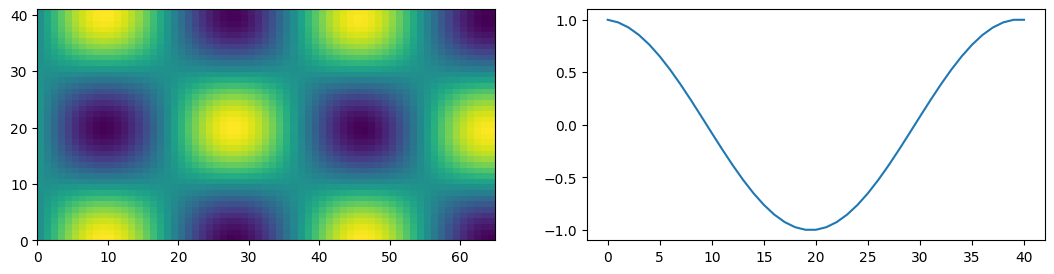

In [144]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('test.out_f')

fig, ax = plt.subplots(ncols=2, figsize=(13, 3))
ax[0].pcolor(data[:, 1:], shading='auto')
ax[1].plot(data[:,10])